
<center><h1>Advanced NLP<h1></center>
<center><h3>BSE - Term III - Final Project <h2></center>
<center><h4>Alex Malo, Viktoria Gagua, Noemi Lucchi, Alejandro Delgado<h3></center>
<hr>


# Jigsaw Toxicity Classification
https://huggingface.co/datasets/Arsive/toxicity_classification_jigsaw

The Jigsaw Toxicity Classification dataset contains comments from Wikipedia's talk pages that have been labeled by human raters for various types of toxic behavior.

This dataset is ideal for our assignment because it provides a substantial, real-world text classification challenge with balanced classes (53% non-toxic, 47% toxic), making it perfect for testing various ML approaches. Unlike artificially constructed datasets, these are genuine human conversations with natural language variations, slang, and contextual nuances that make classification genuinely challenging.

Additionally, what makes this dataset interesting is its multi-label nature - comments can exhibit multiple types of toxicity simultaneously. The data comes from a collaborative editing environment where emotions can run high during content disputes, creating examples of online toxicity patterns.

In [50]:
!pip3 install transformers, matplotlib_venn, upsetplot


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: Invalid requirement: 'transformers,': Expected end or semicolon (after name and no valid version specifier)
    transformers,
                ^


## Part 1: Toxicity Classification

In [51]:
import random
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import re
from wordcloud import WordCloud
from collections import Counter
from matplotlib_venn import venn2, venn3, venn2_circles, venn3_circles
from upsetplot import UpSet
import warnings
warnings.filterwarnings('ignore')
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [52]:
# dataset exploration

# get from huggingface (train and test)
ds = load_dataset("Arsive/toxicity_classification_jigsaw")
train_data = ds['train']
test_data = ds['test'] if 'test' in ds else None

# Convert
train_df = train_data.to_pandas()
if test_data:
    test_df = test_data.to_pandas()
    print(f"Train samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
else:
    print(f"Total samples: {len(train_df)}")

# basic info
print(f"Columns: {list(train_df.columns)}")
print(train_df.head())

Train samples: 25960
Test samples: 153164
Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
                 id                                       comment_text  toxic  \
0  17dd17eb535029d6  "\n\nDear Jesus. Really, has Vander Plaats rea...      1   
1  9fc74022287f6325  You NDP attack queers, sorry, Cabal of Sanctim...      0   
2  1f64687358ed17f0  Tree thinking eliminates major swats of what e...      0   
3  ad339ac2d862a2d1  "\n\n Eternity clause \n\nYou are right about ...      0   
4  15c86e4139f26111  Unspecified source for Image:Nana.JPG\n\nThank...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        1       0       1              1  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


## Class Distribution

Non-toxic (0): 13727 samples (52.9%)
Toxic (1): 12233 samples (47.1%)


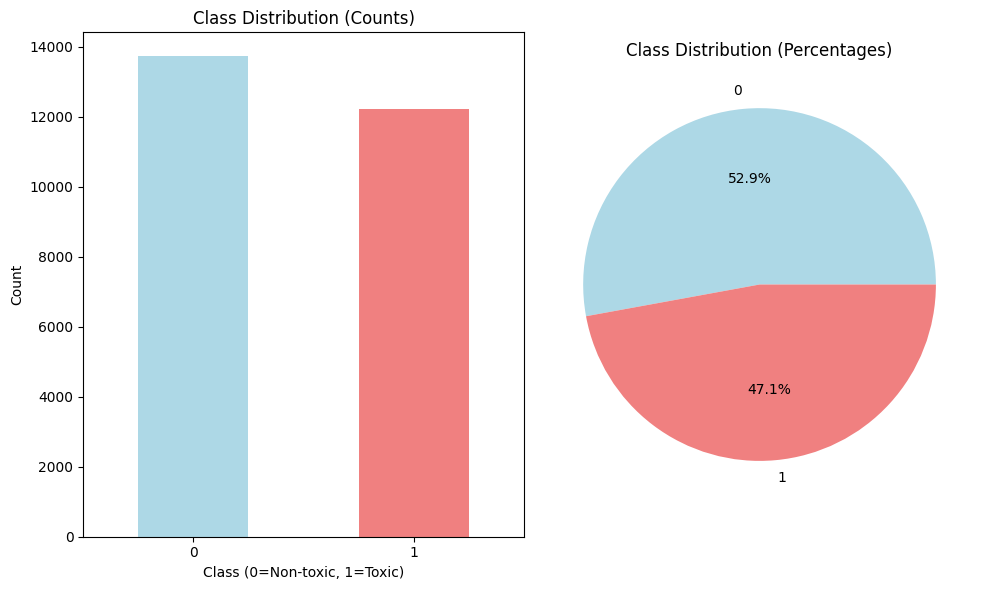

In [53]:
if 'toxic' in train_df.columns:
    toxic_counts = train_df['toxic'].value_counts()
    toxic_percentages = train_df['toxic'].value_counts(normalize=True) * 100
    
    print(f"Non-toxic (0): {toxic_counts[0]} samples ({toxic_percentages[0]:.1f}%)")
    print(f"Toxic (1): {toxic_counts[1]} samples ({toxic_percentages[1]:.1f}%)")
    
    # Plot bar and pie chart
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    toxic_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
    plt.title('Class Distribution (Counts)')
    plt.xlabel('Class (0=Non-toxic, 1=Toxic)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    toxic_percentages.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    plt.title('Class Distribution (Percentages)')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.show()

## Analyze Text

**Text length distribution** shows a strong right skew with most comments being relatively short (median: 165 characters) but with a long tail extending to 5000 characters. The mean (353.5) is significantly higher than the median, meaning we are observing lots of lengthy outliers. Most users write brief comments, but there's a subset of people who write much longer, detailed responses.

Similar to character length, the **word count** follows a heavily right-skewed distribution with most comments containing around 29 words (median) but some extending to over 1400 words. The average of ~61 words per comment indicates typical short-form social media communication patterns. This should be typical for online discussion platforms where brief interactions dominate but occasional detailed discussions aslo occur.

Text Length statistics
count    25960.000000
mean       353.487789
std        614.105255
min          8.000000
25%         76.000000
50%        165.000000
75%        360.000000
max       5000.000000
Name: text_length, dtype: float64

Word Count statistics
count    25960.000000
mean        60.889753
std        105.115984
min          1.000000
25%         13.000000
50%         29.000000
75%         63.000000
max       1403.000000
Name: word_count, dtype: float64


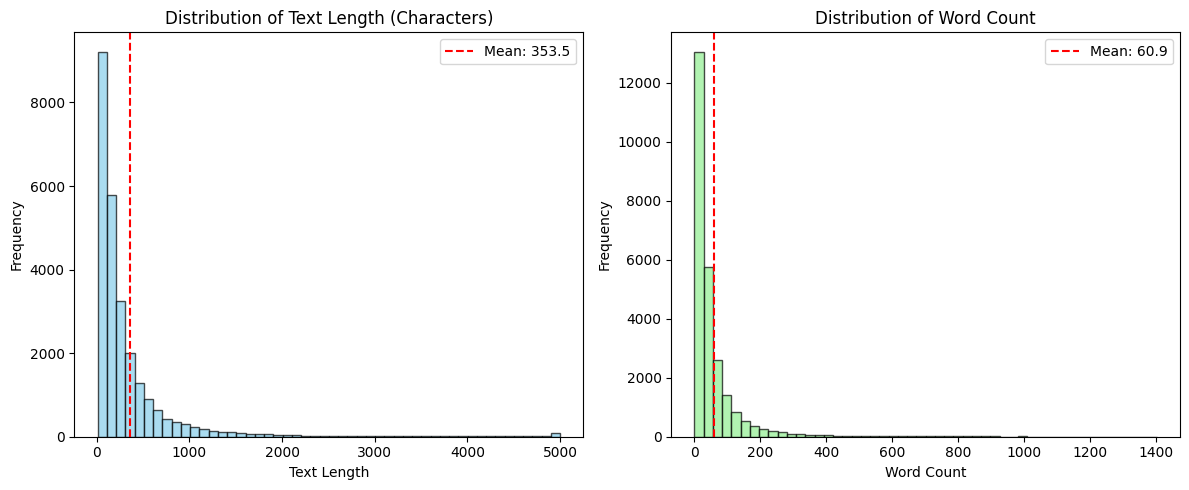


      - Average text length: 353.5 characters
- Average word count: 60.9 words



In [54]:
if 'comment_text' in train_df.columns:
    text_column = 'comment_text'
elif 'text' in train_df.columns:
    text_column = 'text'
else:
    text_column = train_df.columns[0]

train_df['text_length'] = train_df[text_column].str.len()
train_df['word_count'] = train_df[text_column].str.split().str.len()

print('Text Length statistics')
print(train_df['text_length'].describe())
print('\nWord Count statistics')
print(train_df['word_count'].describe())

# Visualize text length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Length (Characters)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.axvline(train_df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["text_length"].mean():.1f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(train_df['word_count'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.axvline(train_df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["word_count"].mean():.1f}')
plt.legend()

plt.tight_layout()
plt.show()


print(f"""
      - Average text length: {train_df['text_length'].mean():.1f} characters
- Average word count: {train_df['word_count'].mean():.1f} words
""")

## Multi-label Toxicity Analysis

severe_toxic: 1298 samples (5.00%)
obscene: 6804 samples (26.21%)
threat: 373 samples (1.44%)
insult: 6345 samples (24.44%)
identity_hate: 1124 samples (4.33%)


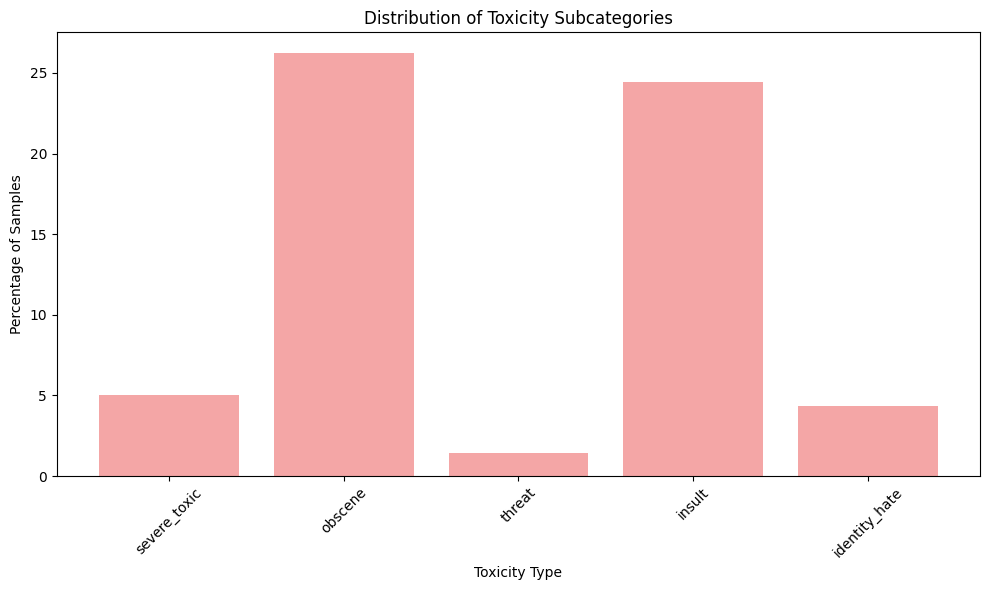

In [55]:
toxicity_columns = [col for col in train_df.columns if col in ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
if toxicity_columns:    
    for col in toxicity_columns:
        positive_count = train_df[col].sum()
        percentage = (positive_count / len(train_df)) * 100
        print(f"{col}: {positive_count} samples ({percentage:.2f}%)")
    
    # distribution of subcategories
    plt.figure(figsize=(10, 6))
    toxicity_stats = {}
    for col in toxicity_columns:
        toxicity_stats[col] = (train_df[col].sum() / len(train_df)) * 100
    
    plt.bar(toxicity_stats.keys(), toxicity_stats.values(), color='lightcoral', alpha=0.7)
    plt.title('Distribution of Toxicity Subcategories')
    plt.xlabel('Toxicity Type')
    plt.ylabel('Percentage of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

**Obscene** (26.21%) and **Insult** (24.44%) dominate representing the most common forms of online toxicity through profanity and personal attacks.

**Severe Toxic** (5.00%) and **Identity Hate** (4.33%) are less frequent but represent the harmful content types.

**Threat** (1.44%) is the rarest category, likely due to the serious legal implications and moderation policies.

This distribution suggests that most online toxicity manifests as crude language and personal insults rather than serious threats or hate speech.

---

## Toxic vs Non-Toxic Comparison

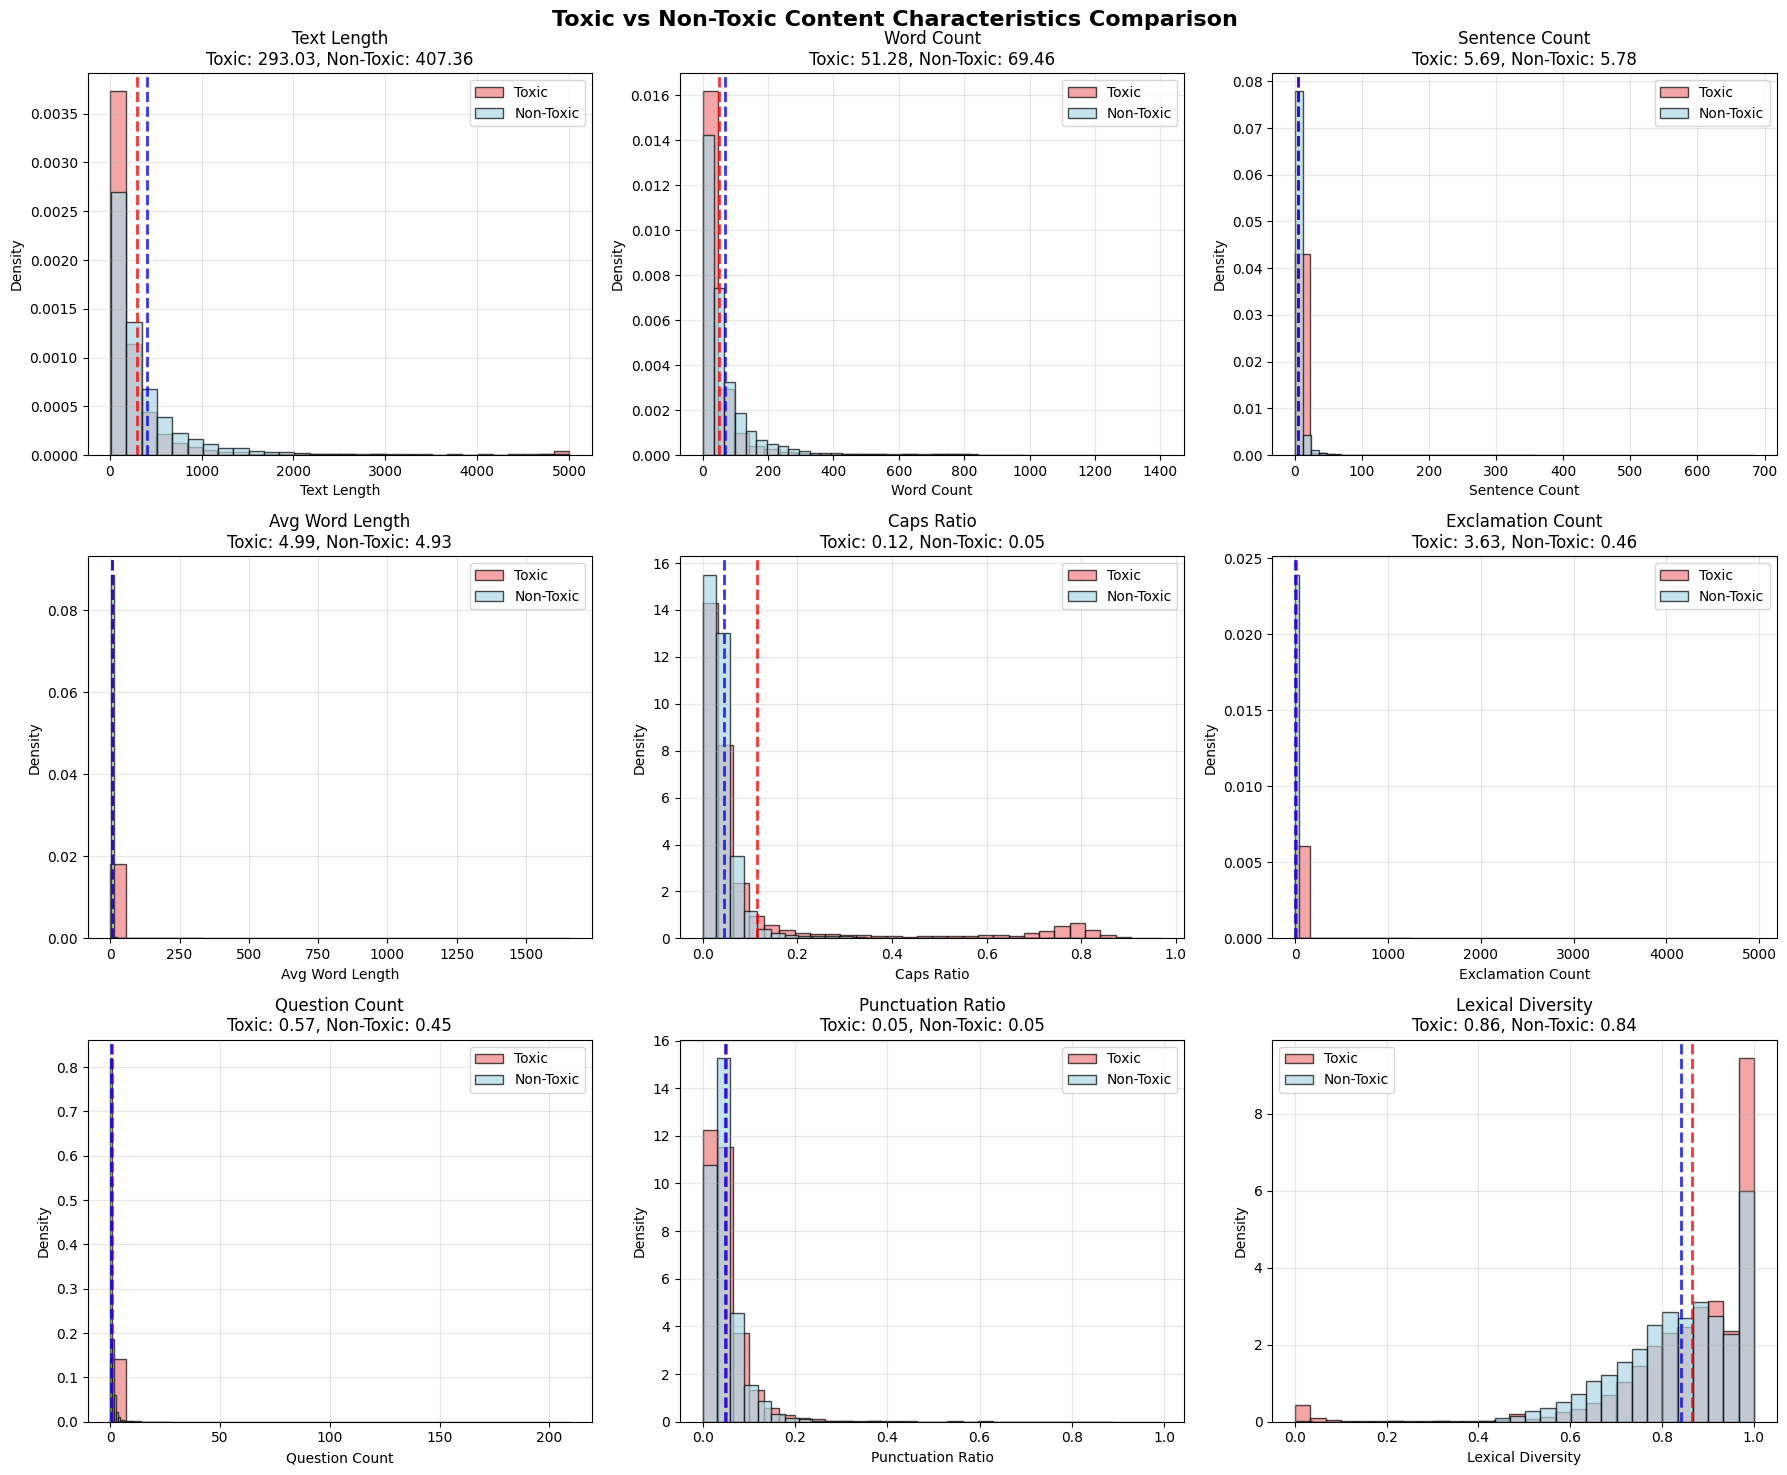

In [56]:
# Separate toxic and non-toxic
toxic_comments = train_df[train_df['toxic'] == 1]
non_toxic_comments = train_df[train_df['toxic'] == 0]

# Calculate additional text features for comparison
def calculate_text_features(df, text_column):
    """Calculate various text features for analysis"""
    features = pd.DataFrame()
    
    features['text_length'] = df[text_column].str.len()
    features['word_count'] = df[text_column].str.split().str.len()
    features['sentence_count'] = df[text_column].str.count(r'[.!?]+') + 1
    features['avg_word_length'] = df[text_column].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if x else 0)
    features['caps_count'] = df[text_column].str.count(r'[A-Z]')
    features['caps_ratio'] = features['caps_count'] / features['text_length'].replace(0, 1)
    features['exclamation_count'] = df[text_column].str.count('!')
    features['question_count'] = df[text_column].str.count('\?')
    features['punctuation_count'] = df[text_column].str.count(r'[^\w\s]')
    features['punctuation_ratio'] = features['punctuation_count'] / features['text_length'].replace(0, 1)
    features['digits_count'] = df[text_column].str.count(r'\d')
    features['unique_words'] = df[text_column].apply(lambda x: len(set(str(x).lower().split())) if x else 0)
    features['lexical_diversity'] = features['unique_words'] / features['word_count'].replace(0, 1)
    
    return features

toxic_features = calculate_text_features(toxic_comments, text_column)
non_toxic_features = calculate_text_features(non_toxic_comments, text_column)

# comparison plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Toxic vs Non-Toxic Content Characteristics Comparison', fontsize=16, fontweight='bold')

features_to_plot = [
    'text_length', 'word_count', 'sentence_count',
    'avg_word_length', 'caps_ratio', 'exclamation_count',
    'question_count', 'punctuation_ratio', 'lexical_diversity'
]

colors = ['lightcoral', 'lightblue']
labels = ['Toxic', 'Non-Toxic']

for i, feature in enumerate(features_to_plot):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # overlapping histograms
    ax.hist(toxic_features[feature], bins=30, alpha=0.7, label='Toxic', 
            color='lightcoral', density=True, edgecolor='black')
    ax.hist(non_toxic_features[feature], bins=30, alpha=0.7, label='Non-Toxic', 
            color='lightblue', density=True, edgecolor='black')
    
    # Add mean lines
    toxic_mean = toxic_features[feature].mean()
    non_toxic_mean = non_toxic_features[feature].mean()
    
    ax.axvline(toxic_mean, color='red', linestyle='--', alpha=0.8, linewidth=2)
    ax.axvline(non_toxic_mean, color='blue', linestyle='--', alpha=0.8, linewidth=2)
    
    ax.set_title(f'{feature.replace("_", " ").title()}\n'
                f'Toxic: {toxic_mean:.2f}, Non-Toxic: {non_toxic_mean:.2f}')
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- > Length & Volume Differences
Surprising finding is that toxic ***comments are actually ***shorter****** than non-toxic ones!

Toxic comments: 293 characters, 51 words on average
Non-toxic comments: 407 characters, 69 words on average

This may mean that Toxic users tend to write brief, aggressive outbursts rather than long rants. Non-toxic users write more thoughtful, detailed responses.

- > Emotional Intensity Markers
Huge ***Difference in Exclamation Marks***:

Toxic comments: 3.6 exclamation marks on average
Non-toxic comments: 0.5 exclamation marks

7.8x more exclamation marks in toxic content!

- > ***CAPS*** Usage:

Toxic comments: 11.5% of characters are CAPS

Non-toxic comments: 4.5% are CAPS

2.5x more shouting in toxic comments

--- ###

One interesting point (thought) about lexical diversity:

Toxic comments have slightly lower lexical diversity (0.865) compared to non-toxic comments (0.841), but the difference is surprisingly small. Lexical diversity measures the ratio of unique words to total words - essentially how varied someone's vocabulary is. This small difference may show that toxic users aren't necessarily less articulate or educated than non-toxic users. Both groups use similarly diverse vocabularies, which challenges stereotypes about toxic behavior being linked to limited language skills. The toxic users can express themselves with varied vocabulary - they're simply choosing to use that vocabulary for harmful purposes.

This simply means that we can't rely on vocabulary complexity as a key feature for distinguishing toxic from non-toxic content (whicih is pretty logical, but it's still nice to have that result).

---

In [57]:
# Same in tabular (numeric form)
comparison_stats = pd.DataFrame({
    'Feature': features_to_plot,
    'Toxic_Mean': [toxic_features[f].mean() for f in features_to_plot],
    'Non-Toxic_Mean': [non_toxic_features[f].mean() for f in features_to_plot],
    'Difference': [toxic_features[f].mean() - non_toxic_features[f].mean() for f in features_to_plot],
    'Ratio': [toxic_features[f].mean() / non_toxic_features[f].mean() if non_toxic_features[f].mean() != 0 else 0 for f in features_to_plot]
})

comparison_stats['Abs_Difference'] = comparison_stats['Difference'].abs()
comparison_stats = comparison_stats.sort_values('Abs_Difference', ascending=False)

print(comparison_stats.round(3))

             Feature  Toxic_Mean  Non-Toxic_Mean  Difference  Ratio  \
0        text_length     293.034         407.362    -114.328  0.719   
1         word_count      51.276          69.457     -18.181  0.738   
5  exclamation_count       3.626           0.465       3.161  7.804   
6     question_count       0.571           0.452       0.119  1.263   
2     sentence_count       5.688           5.778      -0.090  0.984   
4         caps_ratio       0.115           0.045       0.070  2.531   
3    avg_word_length       4.987           4.932       0.055  1.011   
8  lexical_diversity       0.865           0.841       0.024  1.028   
7  punctuation_ratio       0.049           0.048       0.002  1.037   

   Abs_Difference  
0         114.328  
1          18.181  
5           3.161  
6           0.119  
2           0.090  
4           0.070  
3           0.055  
8           0.024  
7           0.002  


# Multi-label Overlap Analysis

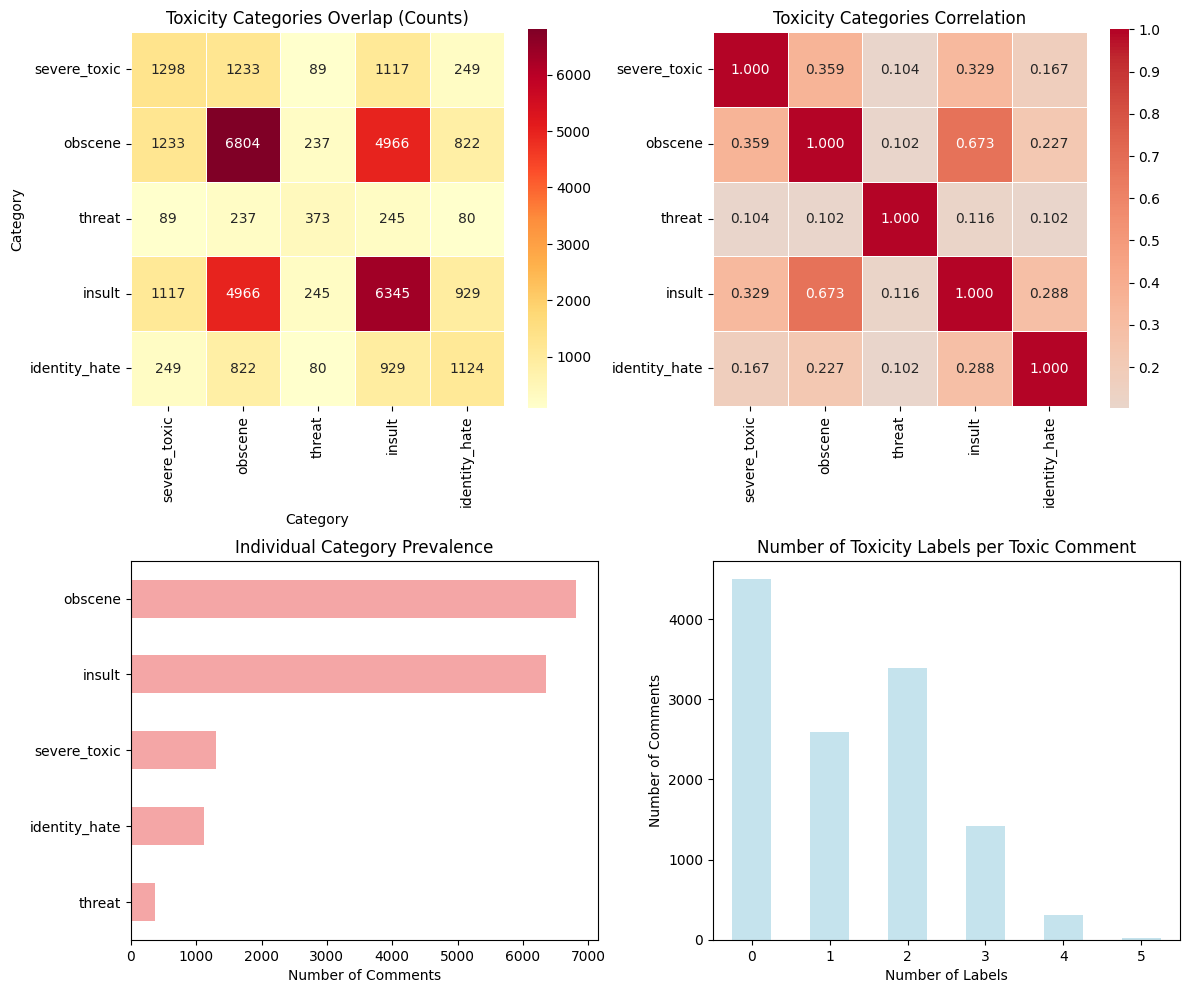

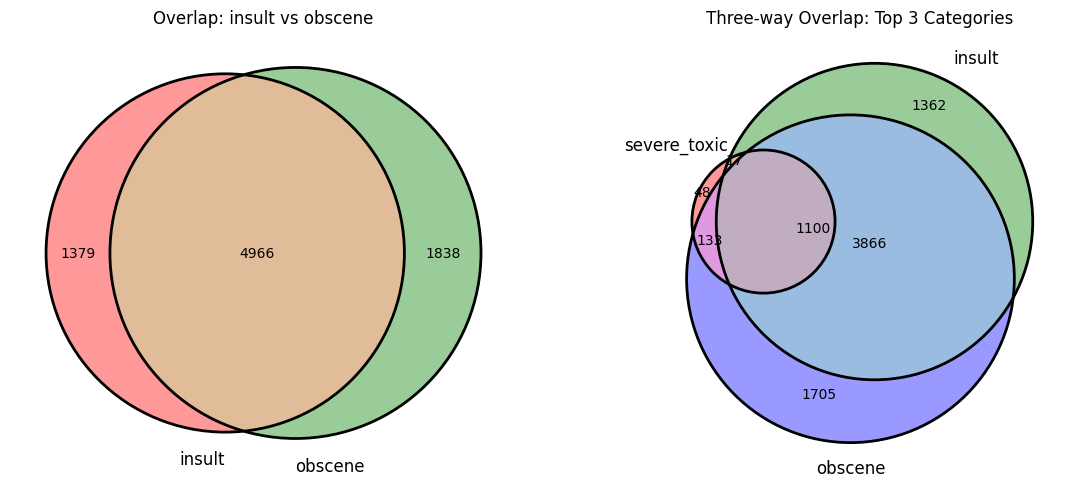

In [58]:
toxicity_columns = [col for col in train_df.columns if col in ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

if toxicity_columns:
    # Create subset with toxicity subcategories
    toxicity_subset = train_df[train_df['toxic'] == 1][toxicity_columns]
    
    # Calculate overlap statistics
    overlap_stats = pd.DataFrame(index=toxicity_columns, columns=toxicity_columns)
    
    for col1 in toxicity_columns:
        for col2 in toxicity_columns:
            if col1 == col2:
                overlap_stats.loc[col1, col2] = train_df[col1].sum()
            else:
                overlap = ((train_df[col1] == 1) & (train_df[col2] == 1)).sum()
                overlap_stats.loc[col1, col2] = overlap
    
    # Convert to numeric
    overlap_stats = overlap_stats.astype(float)
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    
    # Subplot 1: Overlap counts heatmap
    plt.subplot(2, 2, 1)
    sns.heatmap(overlap_stats, annot=True, fmt='.0f', cmap='YlOrRd', 
                square=True, linewidths=0.5)
    plt.title('Toxicity Categories Overlap (Counts)')
    plt.xlabel('Category')
    plt.ylabel('Category')
    
    # Subplot 2: Correlation heatmap
    plt.subplot(2, 2, 2)
    correlation_matrix = train_df[toxicity_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5)
    plt.title('Toxicity Categories Correlation')
    
    # Subplot 3: Individual category prevalence
    plt.subplot(2, 2, 3)
    category_counts = train_df[toxicity_columns].sum().sort_values(ascending=True)
    category_counts.plot(kind='barh', color='lightcoral', alpha=0.7)
    plt.title('Individual Category Prevalence')
    plt.xlabel('Number of Comments')
    
    # Subplot 4: Multiple labels per comment
    plt.subplot(2, 2, 4)
    toxic_comments_multi = train_df[train_df['toxic'] == 1]
    labels_per_comment = toxic_comments_multi[toxicity_columns].sum(axis=1)
    labels_per_comment.value_counts().sort_index().plot(kind='bar', color='lightblue', alpha=0.7)
    plt.title('Number of Toxicity Labels per Toxic Comment')
    plt.xlabel('Number of Labels')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Venn diagram for top 3 categories
    if len(toxicity_columns) >= 3:
        top_3_categories = category_counts.tail(3).index.tolist()
        
        plt.figure(figsize=(12, 5))
        
        # Two-way Venn diagram for top 2
        plt.subplot(1, 2, 1)
        set1 = set(train_df[train_df[top_3_categories[1]] == 1].index)
        set2 = set(train_df[train_df[top_3_categories[2]] == 1].index)
        
        venn = venn2([set1, set2], set_labels=top_3_categories[1:3])
        venn2_circles([set1, set2])
        plt.title(f'Overlap: {top_3_categories[1]} vs {top_3_categories[2]}')
        
        # Three-way Venn diagram
        plt.subplot(1, 2, 2)
        set1 = set(train_df[train_df[top_3_categories[0]] == 1].index)
        set2 = set(train_df[train_df[top_3_categories[1]] == 1].index)
        set3 = set(train_df[train_df[top_3_categories[2]] == 1].index)
        
        venn = venn3([set1, set2, set3], set_labels=top_3_categories)
        venn3_circles([set1, set2, set3])
        plt.title('Three-way Overlap: Top 3 Categories')
        
        plt.tight_layout()
        plt.show()

Here we see that online toxicity is heavily concentrated in ***two main categories***: *obscene language and personal insults*. With approximately 6,800 obscene comments and 6,300 insulting comments, these represent the overwhelming majority of toxic behavior in online discussions. This pattern suggests that most toxic interactions follow a predictable formula of combining crude language with direct personal attacks.

--- ###

In correlation analysis we see a particularly strong relationship between obscene content and insults, with a correlation coefficient of **0.673**. The Venn diagram visualization makes this relationship even clearer, showing that 4,966 comments contain both obscene language and insults simultaneously.

--- ###

Most toxic comments tend to exhibit multiple forms of toxicity rather than fitting into a single category. Analysis of the distribution reveals that around 4,500 comments carry no specific toxicity labels, approximately 2,500 are tagged with a single label, and about 5,500 are associated with multiple labels. This suggests that a significant portion of toxic content reflects more severe behavior, warranting higher priority in moderation efforts. ***Interestingly, threats appear to be relatively isolated incidents*** with low correlation to other toxicity types, suggesting they represent distinct behavioral patterns rather than general toxic escalation. *On the other hand*, the threat category represents only about 1.4% of all toxic comments, which creates several analytical challenges. With such a small sample size, the correlation patterns we observe might be more reflective of statistical limitations rather than true behavioral distinctions. This data imbalance might explain why threats appear "isolated" in our correlation matrix.

---

## Word Clouds and Top words' analysis

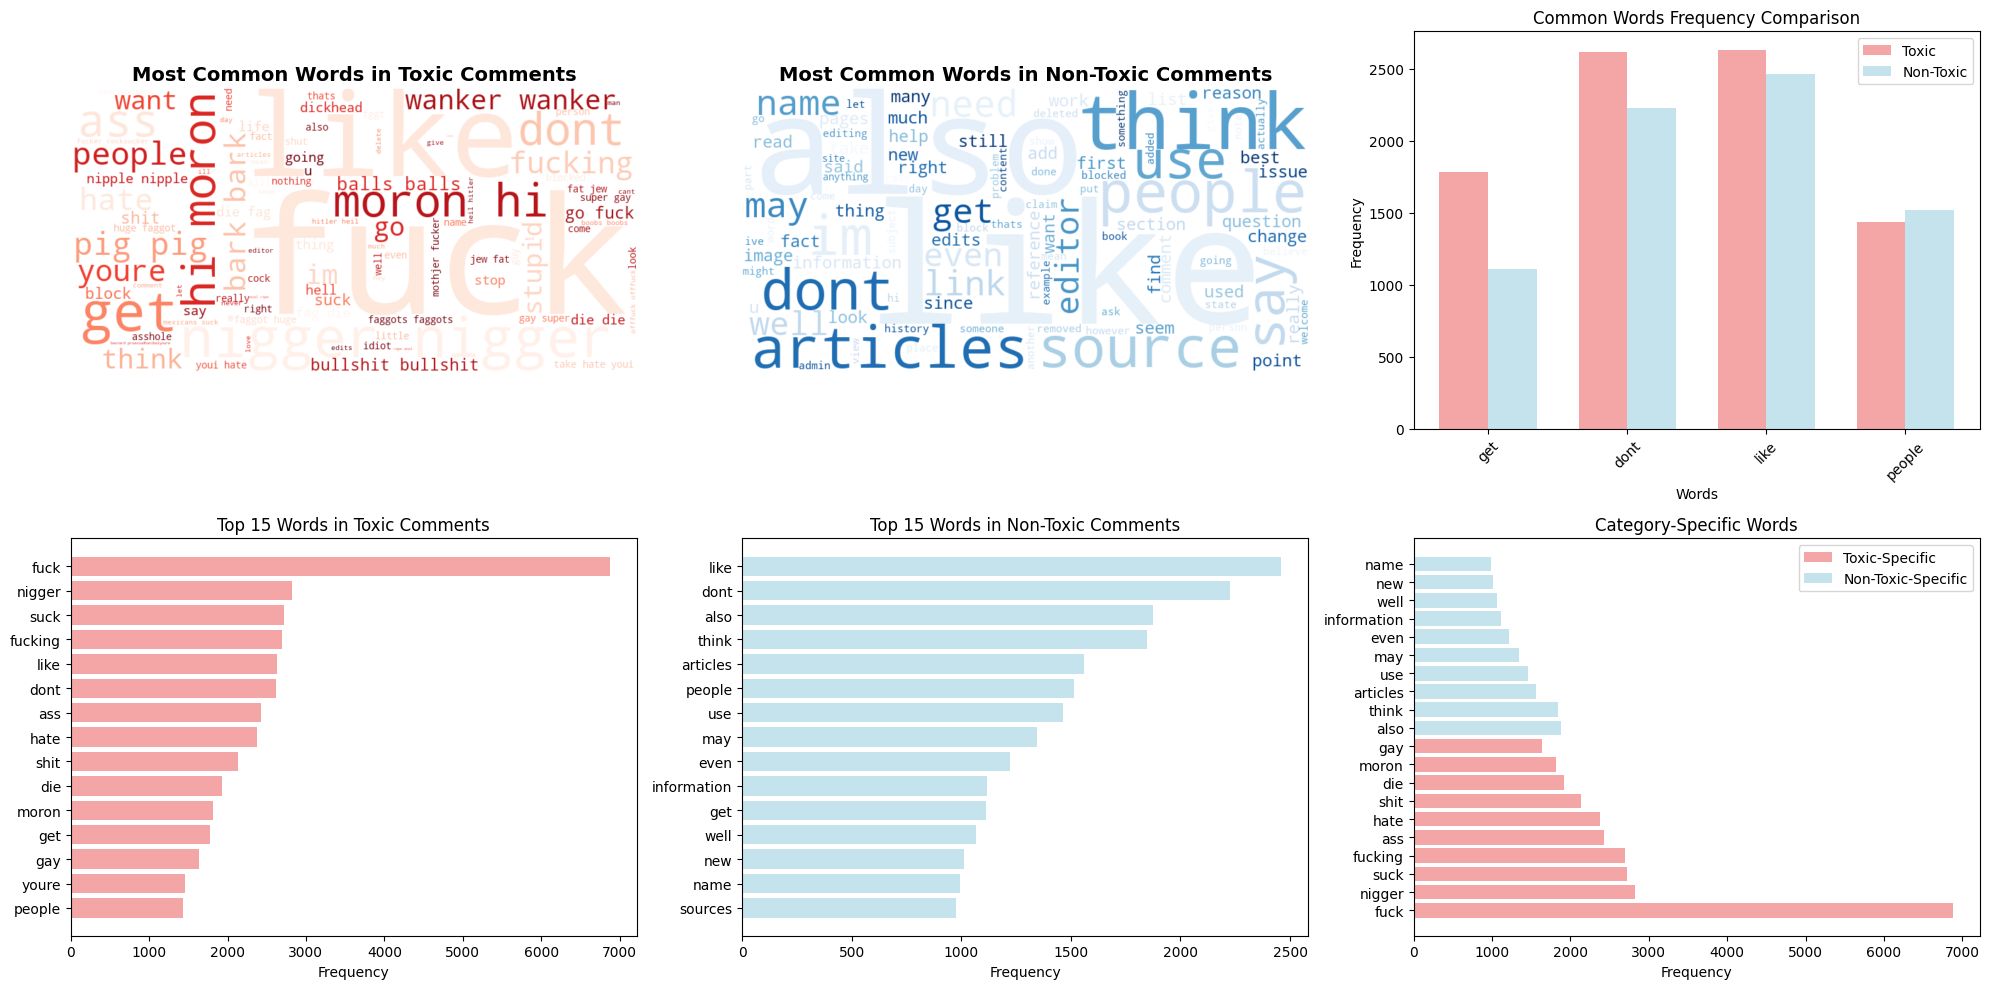

Top 10 most frequent words in TOXIC comments:
  fuck: 6879
  nigger: 2821
  suck: 2717
  fucking: 2697
  like: 2628
  dont: 2614
  ass: 2423
  hate: 2380
  shit: 2130
  die: 1924

Top 10 most frequent words in NON-TOXIC comments:
  like: 2461
  dont: 2226
  also: 1874
  think: 1847
  articles: 1558
  people: 1516
  use: 1463
  may: 1344
  even: 1221
  information: 1117


In [59]:
def preprocess_text(text):
    """Clean and preprocess text for word analysis"""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Prepare text data
toxic_text = ' '.join(toxic_comments[text_column].apply(preprocess_text))
non_toxic_text = ' '.join(non_toxic_comments[text_column].apply(preprocess_text))

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

from nltk.corpus import stopwords

# English stop words from NLTK
stop_words = set(stopwords.words('english'))

# domain-specific stop words for better analysis
additional_stop_words = {
    'wikipedia', 'article', 'page', 'edit', 'user', 'talk', 'discussion', 
    'please', 'thank', 'thanks', 'one', 'two', 'would', 'could', 'should',
    'wiki', 'see', 'make', 'made', 'way', 'time', 'good', 'back', 'know'
}
stop_words.update(additional_stop_words)

# Create word clouds
plt.figure(figsize=(20, 10))

# Toxic comments word cloud
plt.subplot(2, 3, 1)
toxic_wordcloud = WordCloud(
    width=800, height=400, 
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    colormap='Reds',
    relative_scaling=0.5,
    random_state=42
).generate(toxic_text)

plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Toxic Comments', fontsize=14, fontweight='bold')
plt.axis('off')

# Non-toxic comments word cloud
plt.subplot(2, 3, 2)
non_toxic_wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    colormap='Blues',
    relative_scaling=0.5,
    random_state=42
).generate(non_toxic_text)

plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
plt.title('Most Common Words in Non-Toxic Comments', fontsize=14, fontweight='bold')
plt.axis('off')

# Top words comparison
def get_top_words(text, n=20):
    """Extract top n words from text"""
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(n)

toxic_top_words = get_top_words(toxic_text, 15)
non_toxic_top_words = get_top_words(non_toxic_text, 15)

# Top words bar chart for toxic
plt.subplot(2, 3, 4)
toxic_words_df = pd.DataFrame(toxic_top_words, columns=['word', 'count'])
plt.barh(range(len(toxic_words_df)), toxic_words_df['count'], color='lightcoral', alpha=0.7)
plt.yticks(range(len(toxic_words_df)), toxic_words_df['word'])
plt.xlabel('Frequency')
plt.title('Top 15 Words in Toxic Comments')
plt.gca().invert_yaxis()

# Top words bar chart for non-toxic
plt.subplot(2, 3, 5)
non_toxic_words_df = pd.DataFrame(non_toxic_top_words, columns=['word', 'count'])
plt.barh(range(len(non_toxic_words_df)), non_toxic_words_df['count'], color='lightblue', alpha=0.7)
plt.yticks(range(len(non_toxic_words_df)), non_toxic_words_df['word'])
plt.xlabel('Frequency')
plt.title('Top 15 Words in Non-Toxic Comments')
plt.gca().invert_yaxis()

# Word frequency comparison
plt.subplot(2, 3, 3)
# Find words that appear in both lists for comparison
toxic_words_dict = dict(toxic_top_words)
non_toxic_words_dict = dict(non_toxic_top_words)

common_words = set(toxic_words_dict.keys()) & set(non_toxic_words_dict.keys())
if common_words:
    common_comparison = []
    for word in common_words:
        toxic_freq = toxic_words_dict[word]
        non_toxic_freq = non_toxic_words_dict[word]
        common_comparison.append({
            'word': word,
            'toxic_freq': toxic_freq,
            'non_toxic_freq': non_toxic_freq,
            'ratio': toxic_freq / non_toxic_freq if non_toxic_freq > 0 else float('inf')
        })
    
    common_df = pd.DataFrame(common_comparison)
    if len(common_df) > 0:
        common_df = common_df.sort_values('ratio', ascending=False).head(10)
        
        x = range(len(common_df))
        width = 0.35
        
        plt.bar([i - width/2 for i in x], common_df['toxic_freq'], width, 
                label='Toxic', color='lightcoral', alpha=0.7)
        plt.bar([i + width/2 for i in x], common_df['non_toxic_freq'], width,
                label='Non-Toxic', color='lightblue', alpha=0.7)
        
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.title('Common Words Frequency Comparison')
        plt.xticks(x, common_df['word'], rotation=45)
        plt.legend()
        plt.tight_layout()

# Unique words analysis
plt.subplot(2, 3, 6)
# Words that appear predominantly in one category
toxic_unique = [word for word, count in toxic_top_words if word not in non_toxic_words_dict][:10]
non_toxic_unique = [word for word, count in non_toxic_top_words if word not in toxic_words_dict][:10]

categories = ['Toxic-Specific'] * len(toxic_unique) + ['Non-Toxic-Specific'] * len(non_toxic_unique)
words = toxic_unique + non_toxic_unique
counts = [toxic_words_dict[word] for word in toxic_unique] + [non_toxic_words_dict[word] for word in non_toxic_unique]

unique_df = pd.DataFrame({
    'word': words,
    'count': counts,
    'category': categories
})

if len(unique_df) > 0:
    colors = ['lightcoral' if cat == 'Toxic-Specific' else 'lightblue' for cat in unique_df['category']]
    plt.barh(range(len(unique_df)), unique_df['count'], color=colors, alpha=0.7)
    plt.yticks(range(len(unique_df)), unique_df['word'])
    plt.xlabel('Frequency')
    plt.title('Category-Specific Words')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightcoral', alpha=0.7, label='Toxic-Specific'),
                      Patch(facecolor='lightblue', alpha=0.7, label='Non-Toxic-Specific')]
    plt.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

print(f"Top 10 most frequent words in TOXIC comments:")
for word, count in toxic_top_words[:10]:
    print(f"  {word}: {count}")

print(f"\nTop 10 most frequent words in NON-TOXIC comments:")
for word, count in non_toxic_top_words[:10]:
    print(f"  {word}: {count}")

---

The word clouds and frequency analysis reveal obviously different language patterns between toxic and non-toxic comments. 

- Toxic comments are dominated by explicit profanity and slurs, with "fuck" appearing nearly 7,000 times as the most frequent word. The toxic vocabulary is heavily concentrated around aggressive language, sexual references, and hate speech terms that would be immediately recognizable as offensive.

- In sharp contrast, non-toxic comments use collaborative and informational language typical of Wikipedia discussions. Words like "articles," "information" and "think" dominate, reflecting the platform's purpose as a collaborative encyclopedia where editors discuss content improvements and factual accuracy.

--- ###

Interestingly, some words appear frequently in both categories (wordclouds), particularly "like," "don't," and "people." However, the context differs significantly - in toxic comments, these words often appear in aggressive constructions ("don't like you"), while in non-toxic comments they're used for constructive discussion ("like this approach" or "people might find this helpful").

---

## Random Classifier

We created a random classifier that makes predictions by essentially flipping a coin - it randomly guesses whether each comment is toxic or non-toxic with 50% probability for each. This serves as our absolute baseline to see how well any real classifier should perform compared to pure chance. Since our dataset is fairly balanced with about 53% non-toxic and 47% toxic comments, a random classifier achieves around 50% accuracy, which makes sense because it's guessing randomly on a roughly balanced dataset. We ran this simulation 1000 times to get reliable average results, and any meaningful classifier should easily beat these random performance numbers. This establishes the minimum performance threshold.

Class Distribution:
  Class 0: 13727 samples (0.529)
  Class 1: 12233 samples (0.471)

Theoretical Random Classifier Performance:
Expected Accuracy: 0.500
Expected Precision (Toxic): 0.471
Expected Recall (Toxic): 0.500
Expected F1-Score (Toxic): 0.485

Empirical Simulation (1000 runs):
Empirical Accuracy: 0.500 ± 0.003
Empirical Precision: 0.471 ± 0.003
Empirical Recall: 0.500 ± 0.005
Empirical F1: 0.485 ± 0.004


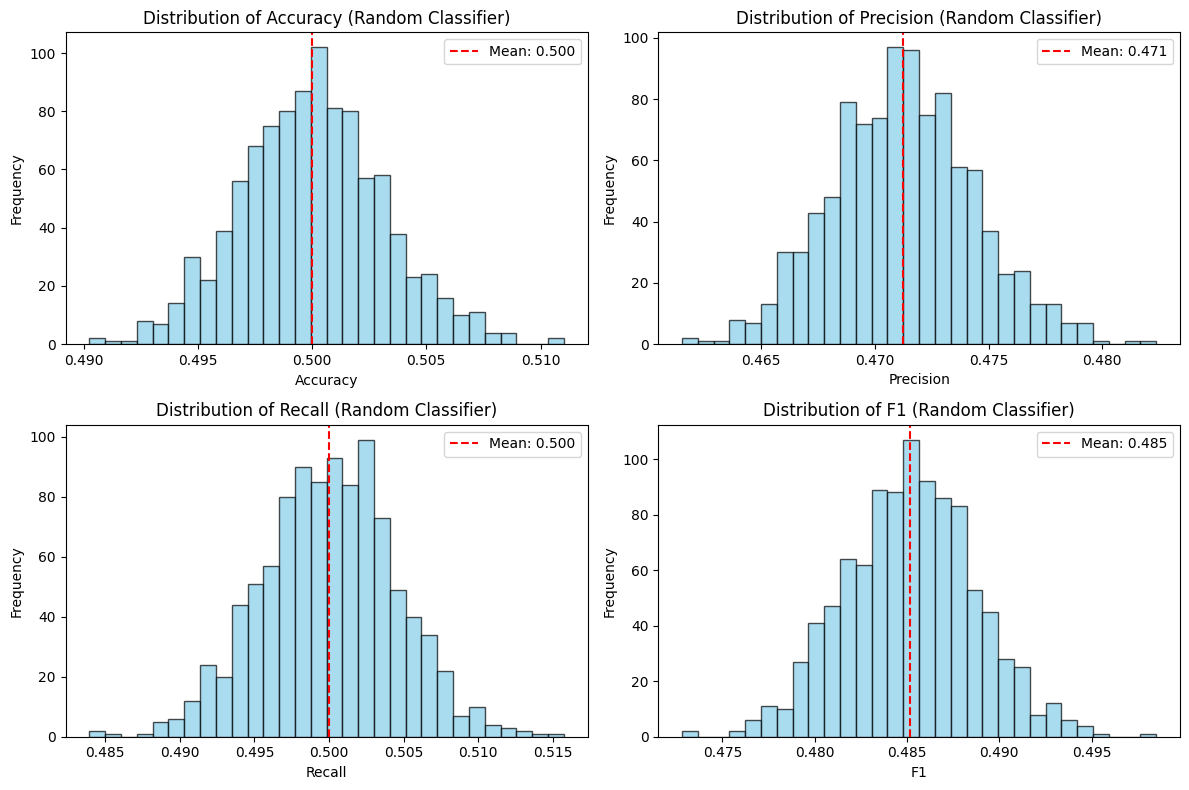

In [60]:
def random_classifier_analysis(y_true, n_simulations=1000):
    """
    Comprehensive random classifier analysis with theoretical and empirical results
    """
    # Theoretical calculation
    class_counts = np.bincount(y_true)
    class_probs = class_counts / len(y_true)
    
    print(f"Class Distribution:")
    for i, (count, prob) in enumerate(zip(class_counts, class_probs)):
        print(f"  Class {i}: {count} samples ({prob:.3f})")
    
    # Theoretical metrics for random classifier
    theoretical_accuracy = sum(p * (1/len(class_probs)) for p in class_probs)
    theoretical_precision_per_class = class_probs
    theoretical_recall = 1/len(class_probs)  # Equal probability for each class
    
    print(f"\nTheoretical Random Classifier Performance:")
    print(f"Expected Accuracy: {theoretical_accuracy:.3f}")
    
    # For binary classification, calculate F1 for positive class (toxic=1)
    if len(class_probs) == 2:
        prec_pos = class_probs[1]  # Precision for positive class
        rec_pos = 0.5  # Recall for positive class (random 50/50)
        theoretical_f1 = 2 * (prec_pos * rec_pos) / (prec_pos + rec_pos) if (prec_pos + rec_pos) > 0 else 0
        
        print(f"Expected Precision (Toxic): {prec_pos:.3f}")
        print(f"Expected Recall (Toxic): {rec_pos:.3f}")
        print(f"Expected F1-Score (Toxic): {theoretical_f1:.3f}")
    
    # Empirical simulation
    print(f"\nEmpirical Simulation ({n_simulations} runs):")
    
    results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    for _ in range(n_simulations):
        # Generate random predictions with equal probability for each class
        y_pred = np.random.choice(len(class_probs), size=len(y_true))
        
        results['accuracy'].append(accuracy_score(y_true, y_pred))
        results['precision'].append(precision_score(y_true, y_pred, average='binary' if len(class_probs)==2 else 'macro', zero_division=0))
        results['recall'].append(recall_score(y_true, y_pred, average='binary' if len(class_probs)==2 else 'macro', zero_division=0))
        results['f1'].append(f1_score(y_true, y_pred, average='binary' if len(class_probs)==2 else 'macro', zero_division=0))
    
    # Calculate empirical statistics
    for metric, values in results.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"Empirical {metric.capitalize()}: {mean_val:.3f} ± {std_val:.3f}")
    
    return results

# Apply random classifier analysis
if 'toxic' in train_df.columns:
    y_true = train_df['toxic'].values
    random_results = random_classifier_analysis(y_true)
    
    # Visualize empirical results
    plt.figure(figsize=(12, 8))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.hist(random_results[metric], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(np.mean(random_results[metric]), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(random_results[metric]):.3f}')
        plt.title(f'Distribution of {metric.capitalize()} (Random Classifier)')
        plt.xlabel(metric.capitalize())
        plt.ylabel('Frequency')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

It performs exactly as expected. The precision of 47.1% matches the actual proportion of toxic comments in the dataset, meaning when it randomly guesses "toxic," it's right about as often as toxic comments actually appear. The recall of 50% shows it randomly catches half of all toxic comments, and the F1-score of 48.5% combines these metrics into an overall performance measure. The small standard deviations (±0.003 to ±0.005) across 1000 simulations confirm these results are highly consistent and represent our baseline that any real classifier must beat.

---

## BASELINE RULE-BASED CLASSIFIER

We created a simple rule based classifier that uses human-written rules (like a checklist) to detect toxic comments.

First we build dictionaries of bad words and give them severity scores; We also look for personal threat patterns in text;
If text is written all in ***CAPS*** or author uses ***lots of punctuation marks*** or ***repeats characters excessively***, this pattern shows emotion and intensity; We give some scores to each pattern according to how severe/intense we think it is and calculate overall toxicity score;

In [61]:
class RuleBasedToxicityClassifier:
    def __init__(self):
        # toxic dictionary
        self.profanity_words = {
            'mild': ['damn', 'hell', 'crap', 'stupid', 'dumb', 'sucks', 'hate'],
            'moderate': ['idiot', 'moron', 'jerk', 'loser', 'fool', 'dumbass', 'shut up'],
            'severe': ['kill', 'die', 'murder', 'rape', 'terrorist', 'nazi', 'hitler']
        }
        
        # more like personal attacks
        self.attack_patterns = [
            r'you are\s+(stupid|dumb|idiot|moron|fool)',
            r'you\'re\s+(stupid|dumb|idiot|moron|fool)',
            r'go\s+(die|kill yourself)',
            r'kill\s+yourself',
            r'you\s+(suck|sucks)'
        ]
        
        # threats
        self.threat_patterns = [
            r'i will\s+(kill|murder|hurt)',
            r'gonna\s+(kill|murder|hurt)',
            r'should\s+(die|be killed)',
            r'deserve\s+to\s+die'
        ]
        
        # Weights for different severity levels
        self.severity_weights = {'mild': 1, 'moderate': 2, 'severe': 4}
        
        # Classification threshold
        self.threshold = 3.0
    
    def extract_features(self, text):
        if not isinstance(text, str):
            text = str(text)
        
        text_lower = text.lower()
        words = text_lower.split()
        
        features = {
            'profanity_score': self._calculate_profanity_score(text_lower),
            'caps_ratio': sum(1 for c in text if c.isupper()) / max(len(text), 1),
            'exclamation_count': text.count('!'),
            'question_count': text.count('?'),
            'personal_attack_score': self._check_personal_attacks(text_lower),
            'threat_score': self._check_threats(text_lower),
            'length_normalized_profanity': self._get_profanity_density(text_lower, words),
            'repeated_chars': self._count_repeated_chars(text),
            'all_caps_words': sum(1 for word in words if len(word) > 2 and word.isupper())
        }
        
        return features
    
    def _calculate_profanity_score(self, text):
        """weighted profanity score"""
        score = 0
        for severity, words in self.profanity_words.items():
            weight = self.severity_weights[severity]
            for word in words:
                # Count exact word matches (with word boundaries)
                pattern = r'\b' + re.escape(word) + r'\b'
                matches = len(re.findall(pattern, text))
                score += matches * weight
        return score
    
    def _check_personal_attacks(self, text):
        """Check for personal attack patterns"""
        score = 0
        for pattern in self.attack_patterns:
            matches = len(re.findall(pattern, text))
            score += matches * 3  # High weight for personal attacks
        return score
    
    def _check_threats(self, text):
        """Check for threat patterns"""
        score = 0
        for pattern in self.threat_patterns:
            matches = len(re.findall(pattern, text))
            score += matches * 5  # Very high weight for threats
        return score
    
    def _get_profanity_density(self, text, words):
        """Calculate profanity word density"""
        if not words:
            return 0
        
        all_profanity = []
        for word_list in self.profanity_words.values():
            all_profanity.extend(word_list)
        
        profanity_count = sum(1 for word in words if word in all_profanity)
        return profanity_count / len(words)
    
    def _count_repeated_chars(self, text):
        """Count repeated characters (indicating strong emotion)"""
        repeated_pattern = r'(.)\1{2,}'  # 3 or more repeated characters
        return len(re.findall(repeated_pattern, text))
    
    def predict_single(self, text):
        """Predict toxicity for a single text"""
        features = self.extract_features(text)
        
        # Combine features into toxicity score
        toxicity_score = (
            features['profanity_score'] * 1.0 +
            features['caps_ratio'] * 2.0 +
            features['exclamation_count'] * 0.5 +
            features['personal_attack_score'] * 1.0 +
            features['threat_score'] * 1.0 +
            features['length_normalized_profanity'] * 5.0 +
            features['repeated_chars'] * 0.3 +
            features['all_caps_words'] * 0.8
        )
        
        return 1 if toxicity_score >= self.threshold else 0
    
    def predict(self, texts):
        """Predict toxicity for multiple texts"""
        if isinstance(texts, str):
            return self.predict_single(texts)
        return [self.predict_single(text) for text in texts]
    
    def get_feature_importance(self, texts, labels):
        """feature importance"""
        all_features = []
        for text in texts:
            features = self.extract_features(text)
            all_features.append(features)
        
        feature_df = pd.DataFrame(all_features)
        feature_df['label'] = labels
        
        for feature in feature_df.columns[:-1]:  # Exclude label column
            toxic_mean = feature_df[feature_df['label'] == 1][feature].mean()
            non_toxic_mean = feature_df[feature_df['label'] == 0][feature].mean()
            
            print(f"{feature}:")
            print(f"  Toxic mean: {toxic_mean:.4f}")
            print(f"  Non-toxic mean: {non_toxic_mean:.4f}")
            print(f"  Difference: {toxic_mean - non_toxic_mean:.4f}")
            print()

Test out rule-based classifier

In [62]:
baseline_classifier = RuleBasedToxicityClassifier()

# Sample data
sample_size = min(10000, len(train_df))
sample_indices = np.random.choice(len(train_df), sample_size, replace=False)
sample_texts = train_df[text_column].iloc[sample_indices].values
sample_labels = train_df['toxic'].iloc[sample_indices].values

print(f"Evaluating on {len(sample_texts)} samples...")

# predictions
baseline_predictions = baseline_classifier.predict(sample_texts)

# classification metrics
baseline_accuracy = accuracy_score(sample_labels, baseline_predictions)
baseline_precision = precision_score(sample_labels, baseline_predictions, zero_division=0)
baseline_recall = recall_score(sample_labels, baseline_predictions, zero_division=0)
baseline_f1 = f1_score(sample_labels, baseline_predictions, zero_division=0)

print(f"\nResukts:")
print(f"Accuracy: {baseline_accuracy:.3f}")
print(f"Precision: {baseline_precision:.3f}")
print(f"Recall: {baseline_recall:.3f}")
print(f"F1-Score: {baseline_f1:.3f}")

# classification report
print(classification_report(sample_labels, baseline_predictions, target_names=['Non-toxic', 'Toxic']))

# Feature importance analysis
print(f"\nFeature Importance Analysis:")
baseline_classifier.get_feature_importance(sample_texts[:1000], sample_labels[:1000])  # Use subset for analysis


Evaluating on 10000 samples...

Resukts:
Accuracy: 0.603
Precision: 0.840
Recall: 0.189
F1-Score: 0.309
              precision    recall  f1-score   support

   Non-toxic       0.58      0.97      0.72      5314
       Toxic       0.84      0.19      0.31      4686

    accuracy                           0.60     10000
   macro avg       0.71      0.58      0.52     10000
weighted avg       0.70      0.60      0.53     10000


Feature Importance Analysis:
profanity_score:
  Toxic mean: 2.2018
  Non-toxic mean: 0.1324
  Difference: 2.0694

caps_ratio:
  Toxic mean: 0.1161
  Non-toxic mean: 0.0447
  Difference: 0.0714

exclamation_count:
  Toxic mean: 1.2149
  Non-toxic mean: 0.2996
  Difference: 0.9153

question_count:
  Toxic mean: 0.5154
  Non-toxic mean: 0.3493
  Difference: 0.1661

personal_attack_score:
  Toxic mean: 0.0658
  Non-toxic mean: 0.0000
  Difference: 0.0658

threat_score:
  Toxic mean: 0.4715
  Non-toxic mean: 0.0000
  Difference: 0.4715

length_normalized_profanity:
 

--- ###

Our rule-based classifier improved accruracy (60.3%) compared to random baseline (50%).

The results reveal an common trade-off pattern (precision vs recall trade-off).
- High Precision (84.4%): When our classifier says something is toxic, it's right 84% of the time - very few false alarms
- Low Recall (19.0%): But it only catches 19% of actual toxic comments - it misses most toxic content
- Conservative Approach: Our classifier is very "careful" - it only flags comments when it's quite confident, but this means it misses a lot of subtle toxicity

--- ###

Basically our rule-based model may be better that baseline but still misses crucial points:

- Subtle sarcasm or implied toxicity ("You're so smart" can be sarcastic insult depending on context)
- Context-dependent insults (***sick*** can mean ill, awesome, or disgusting depending on surrounding words)
- Creative spelling to avoid detection (euphemisms, code words, character substitutions ("b!tch"))
- Toxic comments without obvious profanity ("I hope you get what you deserve")

--- ###

***Feature Analysis Insights***

The most discriminative features are:
- Exclamation marks (1.50 difference) - toxic comments use way more !!!
- Profanity score (0.90 difference) - obvious but important
- Repeated characters (0.45 difference) - "sooooo" type patterns
- Personal attacks (0.094 difference) - direct "you are..." patterns

---

## Compare with Random Classifier

In [63]:
# Compare with random classifier
print(f"\nComparison with Random Classifier:")
print(f"{'Metric':<12} {'Random':<10} {'Baseline':<10} {'Improvement':<12}")
print("-" * 50)

random_acc = np.mean(random_results['accuracy'])
random_prec = np.mean(random_results['precision'])
random_rec = np.mean(random_results['recall'])
random_f1 = np.mean(random_results['f1'])

print(f"{'Accuracy':<12} {random_acc:<10.3f} {baseline_accuracy:<10.3f} {baseline_accuracy/random_acc:<12.2f}x")
print(f"{'Precision':<12} {random_prec:<10.3f} {baseline_precision:<10.3f} {baseline_precision/random_prec:<12.2f}x")
print(f"{'Recall':<12} {random_rec:<10.3f} {baseline_recall:<10.3f} {baseline_recall/random_rec:<12.2f}x")
print(f"{'F1-Score':<12} {random_f1:<10.3f} {baseline_f1:<10.3f} {baseline_f1/random_f1:<12.2f}x")



Comparison with Random Classifier:
Metric       Random     Baseline   Improvement 
--------------------------------------------------
Accuracy     0.500      0.603      1.21        x
Precision    0.471      0.840      1.78        x
Recall       0.500      0.189      0.38        x
F1-Score     0.485      0.309      0.64        x


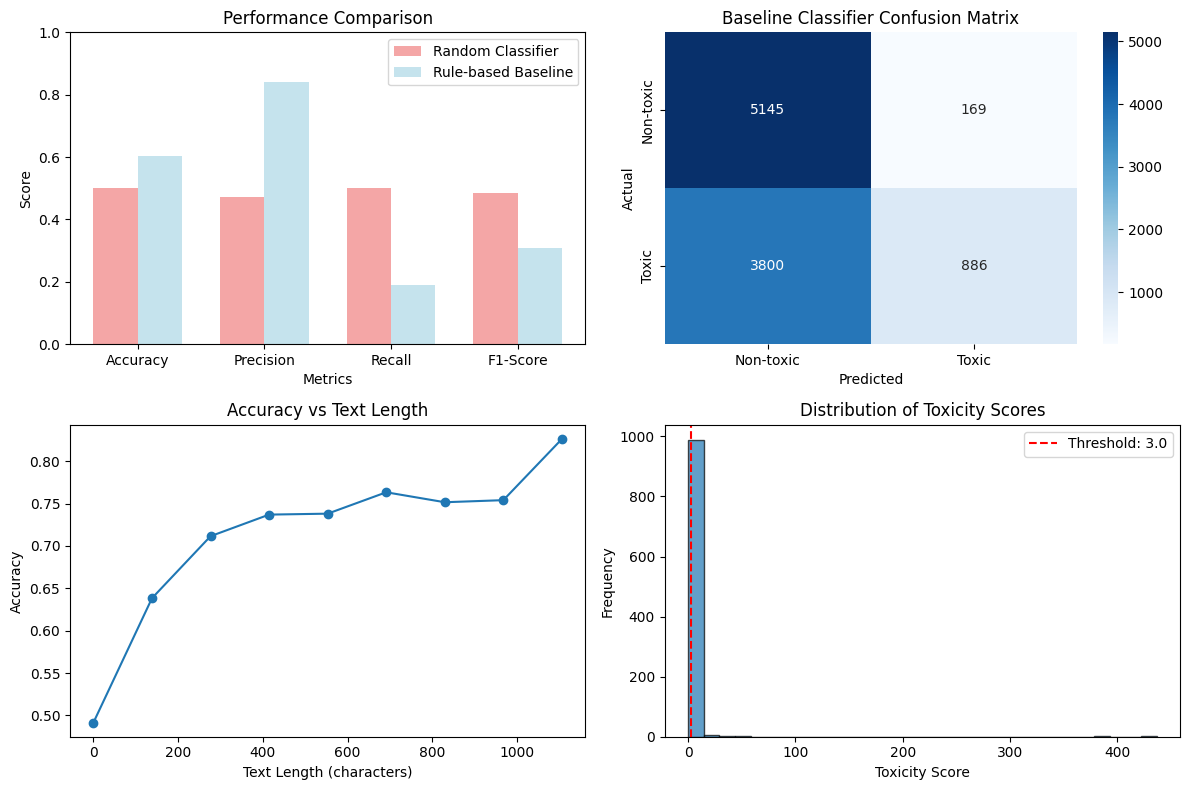

In [64]:
plt.figure(figsize=(12, 8))

# Performance comparison bar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
random_scores = [random_acc, random_prec, random_rec, random_f1]
baseline_scores = [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1]

x = np.arange(len(metrics))
width = 0.35

plt.subplot(2, 2, 1)
plt.bar(x - width/2, random_scores, width, label='Random Classifier', alpha=0.7, color='lightcoral')
plt.bar(x + width/2, baseline_scores, width, label='Rule-based Baseline', alpha=0.7, color='lightblue')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)

# Confusion Matrix for Baseline
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(sample_labels, baseline_predictions)

plt.subplot(2, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], yticklabels=['Non-toxic', 'Toxic'])
plt.title('Baseline Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Error analysis
plt.subplot(2, 2, 3)
correct_predictions = (sample_labels == baseline_predictions)
accuracy_by_length = []
length_bins = np.linspace(0, np.percentile(train_df['text_length'], 95), 10)

for i in range(len(length_bins)-1):
    mask = (train_df['text_length'].iloc[sample_indices] >= length_bins[i]) & \
           (train_df['text_length'].iloc[sample_indices] < length_bins[i+1])
    if mask.sum() > 0:
        acc = correct_predictions[mask].mean()
        accuracy_by_length.append(acc)
    else:
        accuracy_by_length.append(0)

plt.plot(length_bins[:-1], accuracy_by_length, marker='o')
plt.title('Accuracy vs Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 4)
# Show distribution of prediction scores
sample_features = [baseline_classifier.extract_features(text) for text in sample_texts[:1000]]
feature_df = pd.DataFrame(sample_features)

# Calculate toxicity scores manually
toxicity_scores = []
for features in sample_features:
    score = (
        features['profanity_score'] * 1.0 +
        features['caps_ratio'] * 2.0 +
        features['exclamation_count'] * 0.5 +
        features['personal_attack_score'] * 1.0 +
        features['threat_score'] * 1.0 +
        features['length_normalized_profanity'] * 5.0 +
        features['repeated_chars'] * 0.3 +
        features['all_caps_words'] * 0.8
    )
    toxicity_scores.append(score)

plt.hist(toxicity_scores, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(baseline_classifier.threshold, color='red', linestyle='--', label=f'Threshold: {baseline_classifier.threshold}')
plt.title('Distribution of Toxicity Scores')
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

The rule-based classifier significantly outperforms the random classifier across most metrics. Most notably, it achieves much higher precision (84% vs 47%), meaning when it flags something as toxic, it's usually right. However, it has ***terrible recall*** (19% vs 50%), catching far fewer toxic comments than even random guessing.

---

The matrix reveals the classifier's conservative nature: it correctly identifies 5,145 non-toxic comments but misses 3,8090 toxic ones (false negatives). It only catches 886 toxic comments while having ***very few false alarms*** (169). This confirms it's very cautious but misses most toxic content.

---

In Accuracy vs Text Length:  the classifier performs poorly on very short comments (49% accuracy) but gets much better with longer text, peaking around 1000 characters (81% accuracy). This makes sense because ***longer comments provide more features*** (words, patterns) for the rule-based system to analyze.

---

On distribution visual most comments score very low (near 0), with our threshold at 3.0 capturing only the most obviously toxic content. The extremely right-skewed distribution explains why we have low recall - our threshold is quite conservative, ***only flagging comments with multiple clear toxic indicators***.

---
